# Deepwalk with time dynamic penalty

To incentivize proximity between embeddings of a sequence of graphs, one can add a penalty term to the standard skipgram loss used in DeepWalk.

Let $(G_t)_{t=1}^T$ a sequence of graphs, $\mathcal{D_t}$ a set of word-context sampled from the DeepWalk random walk on $G^t$ and $\mathcal{D'_t}$ a set of pairs (central word, fake context), where the fake context is sampled from the nodes of $G_t$. Let $\sigma$ denote the sigmoid function.

$$
\begin{align}
& \mathcal{L}^t_{skipgram} = \sum_{(w,c)\in \mathcal{D_t}} \log \sigma(u^t_w\cdot u^t_c) +\sum_{(w,c')\in \mathcal{D'_t}} \log \sigma(-u^t_w\cdot u^t_{c'}) \\
& \mathcal{L^t_{reg}} = \sum_{(w,c)\in \mathcal{D_t}} \lVert u^{t}_w - u^{t-1}_w \rVert_p + \lVert u^{t}_c - u^{t-1}_c \rVert_p
\end{align}
$$

The DeepWalk model is then trained sequentially on $G_1, \dots, G_T$ by minimizing $\mathcal{L}^t_{skipgram} + \lambda \mathcal{L}^t_{reg}$.

In what follows, we train the sequential DeepWalk without ($\lambda=0$) and with ($\lambda>0$) time dynamic penalty on the bridge removal example and compare the distance between their respective embeddings using the sum of $\mathbb{L}^2$ distance and the 2-Wasserstein metric.

Both distances can be used to metricize the topology of graph embeddings. The $\mathbb{L}^2$ corresponds to the $\mathbb{L}^2$ convergence of empirical measures reprensenting embedding point clouds; intuitively a small $\mathbb{L}^2$ distance corresponds to each point $z^t_i$ being close to $z^{t-1}_{i}$; the Wasserstein distance corresponds to the weak convergence of measures, and characterizes the proximity of the cloud $(z^t_i)_{i=1}^N$ to $(z^{t-1}_i)_{i=1}^N$. Note that the $\mathbb{L}^2$ is sensitive to a reordering of the points, whereas the Wasserstein distance corresponds to the minimum over all possible such reordering.

$\mathbb{L}^2$ penalty is more stringent, and from a practical point of view it is differentiable with explicit derivatives w.r.t the weights of the DeepWalk networks, which allows for an auto-differentiation framework such as Torch; by comparison, Wasserstein distance cannot be easily optimized.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.decomposition import PCA

from graph_embedding_continuity import *

In [2]:
N = 30
# Barabasi-Albert parameter
m = 3

N_TRAIN = 50
EMBEDDING_SIZE = 3
WALK_LENGTH = 10
WINDOW_SIZE = 2
N_NEG = 2
HIDDEN_SIZE = 16

TIME_REG_STRENGTH = 0.2
CLOUD_METRIC_P = 2

USE_CUDA = False
USE_PCA_TO_PLOT = False

In [3]:
# generate a random graph that bridges to clusters
G1 = nx.barabasi_albert_graph(N, 2)
G2 = nx.barabasi_albert_graph(N, 2)

# relabel nodes of G2
d = {}
for v in G1.nodes:
    d[v] = N+v
G2 = nx.relabel_nodes(G2, d)

G_t0 = nx.union(G1, G2)

G_t0.add_edge(N-1, N)
# add some random weights on each edge
for _, _, d in G_t0.edges(data=True):
    d['weight'] = np.random.rand()
    
# save layout
pos = nx.spring_layout(G_t0)

# create a new graph by removing the bridge edge
G_t1 = deepcopy(G_t0)
G_t1.remove_edge(N-1, N)

### No time dynamic penalty

In [4]:
emb_words, emb_contexts = deepwalk_embedding_time_reg([G_t0, G_t1],
                                                      k=EMBEDDING_SIZE,
                                                      n_train=N_TRAIN,
                                                      walk_length=WALK_LENGTH,
                                                      window_size=WINDOW_SIZE,
                                                      n_neg=N_NEG,
                                                      hidden_size = HIDDEN_SIZE,
                                                      use_cuda=USE_CUDA,
                                                      time_reg_strength=0.0,
                                                      cloud_metric_p=CLOUD_METRIC_P,
                                                     )

Epoch : 1/50: 100%|███████████████████████████████████| 60.0/60.0 [00:01<00:00, 40.5it/s, loss=51.3]
Epoch : 10/50: 100%|██████████████████████████████████| 60.0/60.0 [00:01<00:00, 41.1it/s, loss=49.6]
Epoch : 20/50: 100%|██████████████████████████████████| 60.0/60.0 [00:01<00:00, 41.4it/s, loss=36.8]
Epoch : 30/50: 100%|██████████████████████████████████| 60.0/60.0 [00:01<00:00, 41.6it/s, loss=36.5]
Epoch : 40/50: 100%|██████████████████████████████████| 60.0/60.0 [00:01<00:00, 41.3it/s, loss=35.2]
Epoch : 50/50: 100%|██████████████████████████████████| 60.0/60.0 [00:01<00:00, 41.4it/s, loss=34.8]
Epoch : 1/50: 100%|█████| 60.0/60.0 [00:01<00:00, 40.6it/s, skipgram loss=34.6, time dynamic loss=0]
Epoch : 10/50: 100%|██████| 60.0/60.0 [00:01<00:00, 40.7it/s, skipgram loss=33, time dynamic loss=0]
Epoch : 20/50: 100%|████| 60.0/60.0 [00:01<00:00, 40.0it/s, skipgram loss=30.8, time dynamic loss=0]
Epoch : 30/50: 100%|████| 60.0/60.0 [00:01<00:00, 39.9it/s, skipgram loss=31.4, time dynami

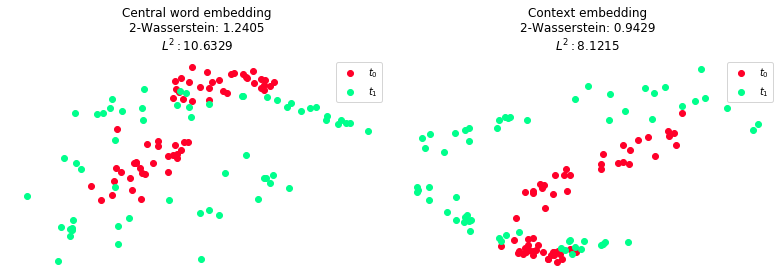

In [5]:
# plot the graph
fig, axes = plt.subplots(figsize=(11,4), nrows=1, ncols=2)

cmap = plt.get_cmap('gist_rainbow')
cNorm  = mpl.colors.Normalize(vmin=0, vmax=len(emb_words))
scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=cmap)
colors = scalarMap.to_rgba(range(len(emb_words)))
    
for t, (emb_word, emb_context, color) in enumerate(zip(emb_words, emb_contexts, colors)):
    wass_word = wasserstein_metric(emb_words[1], emb_words[0])
    wass_context = wasserstein_metric(emb_contexts[1], emb_contexts[0])

    l2_word = torch.norm(emb_words[1]-emb_words[0], 2).item()
    l2_context = torch.norm(emb_contexts[1]-emb_contexts[0], 2).item()
    
    if USE_PCA_TO_PLOT:
        # extract 2 principal components to plot
        pca = PCA(n_components=2)
        emb_word = pca.fit_transform(emb_word.cpu())
        emb_context = pca.fit_transform(emb_context.cpu())

    ax = axes[0]
    ax.scatter(emb_word[:, 0], emb_word[:, 1], label='$t_{}$'.format(t), color=color)
    ax.set_title('Central word embedding\n2-Wasserstein: {:.4f}\n$L^2: {:.4f}$'.format(wass_word, l2_word))

    ax.legend(loc='upper right')
    ax.axis('off')

    ax = axes[1]
    ax.scatter(emb_context[:, 0], emb_context[:, 1], label='$t_{}$'.format(t), color=color)
    ax.set_title('Context embedding\n2-Wasserstein: {:.4f}\n$L^2: {:.4f}$'.format(wass_context, l2_context))
    ax.legend(loc='upper right')
    ax.axis('off')

plt.tight_layout()
plt.show()

###  With time dynamic penalty

In [6]:
emb_words, emb_contexts = deepwalk_embedding_time_reg([G_t0, G_t1],
                                                      k=EMBEDDING_SIZE,
                                                      n_train=N_TRAIN,
                                                      walk_length=WALK_LENGTH,
                                                      window_size=WINDOW_SIZE,
                                                      n_neg=N_NEG,
                                                      hidden_size = HIDDEN_SIZE,
                                                      use_cuda=USE_CUDA,
                                                      time_reg_strength=TIME_REG_STRENGTH,
                                                      cloud_metric_p=CLOUD_METRIC_P,
                                                     )

Epoch : 1/50: 100%|███████████████████████████████████| 60.0/60.0 [00:01<00:00, 41.0it/s, loss=51.1]
Epoch : 10/50: 100%|██████████████████████████████████| 60.0/60.0 [00:01<00:00, 40.2it/s, loss=50.3]
Epoch : 20/50: 100%|██████████████████████████████████| 60.0/60.0 [00:01<00:00, 41.2it/s, loss=44.1]
Epoch : 30/50: 100%|██████████████████████████████████| 60.0/60.0 [00:01<00:00, 40.8it/s, loss=43.8]
Epoch : 40/50: 100%|██████████████████████████████████| 60.0/60.0 [00:01<00:00, 41.0it/s, loss=38.9]
Epoch : 50/50: 100%|██████████████████████████████████| 60.0/60.0 [00:01<00:00, 39.9it/s, loss=31.1]
Epoch : 1/50: 100%|█| 60.0/60.0 [00:01<00:00, 39.8it/s, skipgram loss=31.3, time dynamic loss=0.146]  
Epoch : 10/50: 100%|█| 60.0/60.0 [00:01<00:00, 40.0it/s, skipgram loss=30.6, time dynamic loss=0.56] 
Epoch : 20/50: 100%|█| 60.0/60.0 [00:01<00:00, 39.5it/s, skipgram loss=31.4, time dynamic loss=0.647]
Epoch : 30/50: 100%|██| 60.0/60.0 [00:01<00:00, 40.0it/s, skipgram loss=30, time dynami

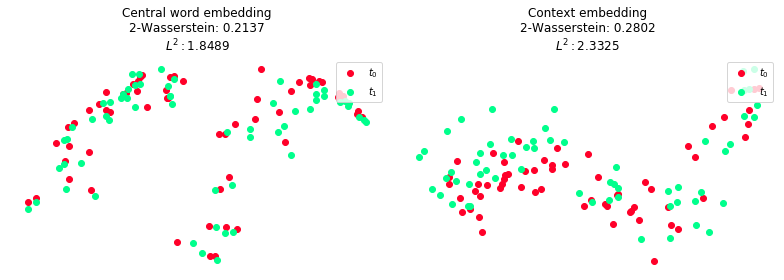

In [7]:
# plot the graph
fig, axes = plt.subplots(figsize=(11,4), nrows=1, ncols=2)

cmap = plt.get_cmap('gist_rainbow')
cNorm  = mpl.colors.Normalize(vmin=0, vmax=len(emb_words))
scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=cmap)
colors = scalarMap.to_rgba(range(len(emb_words)))
    
for t, (emb_word, emb_context, color) in enumerate(zip(emb_words, emb_contexts, colors)):
    wass_word = wasserstein_metric(emb_words[1], emb_words[0])
    wass_context = wasserstein_metric(emb_contexts[1], emb_contexts[0])

    l2_word = torch.norm(emb_words[1]-emb_words[0], 2).item()
    l2_context = torch.norm(emb_contexts[1]-emb_contexts[0], 2).item()
    
    if USE_PCA_TO_PLOT:
        # extract 2 principal components to plot
        pca = PCA(n_components=2)
        emb_word = pca.fit_transform(emb_word.cpu())
        emb_context = pca.fit_transform(emb_context.cpu())

    ax = axes[0]
    ax.scatter(emb_word[:, 0], emb_word[:, 1], label='$t_{}$'.format(t), color=color)
    ax.set_title('Central word embedding\n2-Wasserstein: {:.4f}\n$L^2: {:.4f}$'.format(wass_word, l2_word))
    ax.legend(loc='upper right')
    ax.axis('off')

    ax = axes[1]
    ax.scatter(emb_context[:, 0], emb_context[:, 1], label='$t_{}$'.format(t), color=color)
    ax.set_title('Context embedding\n2-Wasserstein: {:.4f}\n$L^2: {:.4f}$'.format(wass_context, l2_context))
    ax.legend(loc='upper right')
    ax.axis('off')

plt.tight_layout()
plt.show()